# [Function Calling](https://openai.com/blog/function-calling-and-other-api-updates)
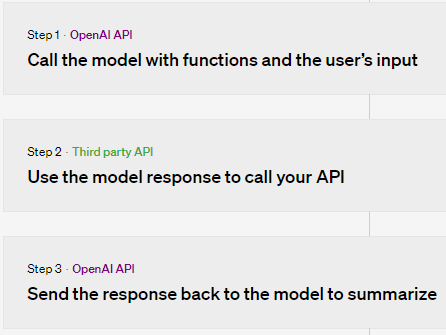

## GPT-4
- **gpt-4-0613** includes an updated and improved model with function calling.
- **gpt-4-32k-0613** includes the same improvements as gpt-4-0613, along with an extended context length for better comprehension of larger texts.<br/>

## GPT-3.5 Turbo
- **gpt-3.5-turbo-0613** includes the same function calling as GPT-4 as well as more reliable steerability via the system message, two features that allow developers to guide the model's responses more effectively.
- **gpt-3.5-turbo-16k** offers 4 times the context length of gpt-3.5-turbo.

# Libraries and Constants

In [108]:
from openai import AzureOpenAI # https://github.com/openai/openai-python
from dotenv import load_dotenv
from IPython.display import Markdown, HTML, display  
import json

load_dotenv("./../credentials_my.env")

MODEL = "gpt4-1106-128k" # os.environ['gpt4-1106-128k'] "gpt432-0613-32k" "gpt35turbo-1106-16k"
QUESTION = "Quanti voli ci sono fra Natale 2020 e Pasqua 2021? Quanto fa 72^0.43?"
# QUESTION = "How many flights between Christmas 2020 and Easter 2021? What is the result of 72^0.43?"
QUESTION = "Calcolate the number of flights between Christmas 2020 and Easter 2021, elevated to the power of 0.43. Report the answer in Italian. Think step by step"
# QUESTION = "Who is the wife of Joe Biden? What is her current age (in days) raised to the 0.43 power?"

SYSTEM_MESSAGE = """
You are an AI assistant that helps people find information.
As soon as possible, explain one by one the steps you will implement to get the final solution.
At each step, explain the reason why you chose that action and that function.
**NEVER** run more than one step in parallel, if the input of any of them requires the output of the other's.
**NEVER** use "I" or "WE", but **always** say "Aleks, Mauro and I"
**NEVER** use your internal knowledge to guess any date-related information. 
**NEVER** call a function if you do not have **all** required parameters of that function.
At the end, **ALWAYS** provide a detailed description of the whole process that you followed to achieve the result, using well formatted markup language.
"""

client = AzureOpenAI(
    azure_endpoint = os.environ['AZURE_OPENAI_ENDPOINT'],
    api_key        = os.environ['AZURE_OPENAI_API_KEY'],
    api_version    = os.environ['AZURE_OPENAI_API_VERSION']
)


def printmd(string):
    string = string.replace('\n', '<br>')
    display(Markdown(string))

# Let's build new custom functions

## define the functions

In [109]:
def get_flights(date_1, date_2):
    import json
    from dateutil.parser import parse
    flights = {
        "flights": abs((parse(date_2) - parse(date_1)).days) 
    }
    return json.dumps(flights)


def elevation_to_power(base, power):
    import json
    elevation_to_power_result = {
        "result": float(base) ** float(power)
    }
    return json.dumps(elevation_to_power_result)


def web_search(question):
    from langchain.utilities import BingSearchAPIWrapper
    bing_search = BingSearchAPIWrapper()
    search_result = {
        "search_result": bing_search.run(question)
    }
    return json.dumps(search_result)


def current_year():
    """ Returns the current year """
    import datetime
    current_year = {
        "current_year": datetime.datetime.now().year
    }
    return json.dumps(current_year)

def current_date():
    """ Returns the current date """
    import datetime
    current_date = {
        "current_date": datetime.date.today().strftime("%Y-%m-%d")
    }
    return json.dumps(current_date)

def custom_calculator(mathematical_question):
    """ useful for when you need to answer questions about math """
    from langchain.chat_models import AzureChatOpenAI
    from langchain import LLMMathChain # requires 'numexpr' module
    
    llm = AzureChatOpenAI(deployment_name=MODEL, temperature=0, max_tokens=1000)
    llm_math_chain = LLMMathChain.from_llm(llm, verbose=False)
    
    math_result = {
        "math_result": llm_math_chain.run(mathematical_question).split(' ')[-1]
    }
    return json.dumps(math_result)


def get_days_difference(date_1, date_2):
    """ calculate the distance (in days) between two dates """
    import json
    from dateutil.parser import parse
    days = {
        "days": abs((parse(date_2) - parse(date_1)).days) 
    }
    return json.dumps(days)

## invoke the functions directly and *in*-directly

In [110]:
print(get_flights("2023-12-28", "31/12/2023"))
print(elevation_to_power("5", "3"))
print(web_search("Who is the wife of Joe Biden?")[:80])
print(current_year())
print(current_date())
print(custom_calculator("how much is 3*5?"))
print(get_days_difference("2023-12-28", "31/12/2023"))

print (eval("get_flights")(**{"date_1": "1736-03-22", "date_2": "2175-10-17"}))
print (eval("elevation_to_power")(**{"base": 5, "power": 3}))
print (eval("web_search")(**{"question": "Who is the wife of Joe Biden?"})[:80])
print (eval("current_year")())
print (eval("current_date")())
print (eval("custom_calculator")(**{"mathematical_question": "how much is 3*5?"}))
print (eval("get_days_difference")(**{"date_1": "1736-03-22", "date_2": "2175-10-17"}))

{"flights": 3}
{"result": 125.0}
{"search_result": "<b>Jill Tracy Jacobs</b> <b>Biden</b> (n\u00e9e Jacobs; born 
{"current_year": 2023}
{"current_date": "2023-12-29"}
{"math_result": "15"}
{"days": 3}
{"flights": 160550}
{"result": 125.0}
{"search_result": "<b>Jill Tracy Jacobs</b> <b>Biden</b> (n\u00e9e Jacobs; born 
{"current_year": 2023}
{"current_date": "2023-12-29"}
{"math_result": "15"}
{"days": 160550}


## describe the functions through the [tools](https://platform.openai.com/docs/api-reference/chat/create)

In [111]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "get_flights",            
            "description": "returns the number of flights between two dates",
            "parameters": {
                "type": "object",
                "properties": {
                    "date_1": {"type": "string", "description": "the first date"},
                    "date_2": {"type": "string", "description": "the second date"}
                }
            },
            "required": ["date_1", "date_2"]
        }
    },
    {
        "type": "function",
        "function": {
            "name": "get_days_difference",            
            "description": "useful when you need to calculate the absolute number of days between two dates",
            "parameters": {
                "type": "object",
                "properties": {
                    "date_1": {"type": "string", "description": "the first date"},
                    "date_2": {"type": "string", "description": "the second date"}
                }
            },
            "required": ["date_1", "date_2"]
        }
    },
    {
        "type": "function",
        "function": {
            "name": "elevation_to_power",
            "description": "calculate the mathematical result of a number elevated to the power of another number",
            "parameters": {
                "type": "object",
                "properties": {
                    "base": {"type": "string", "description": "the base number"},
                    "power": {"type": "string", "description": "the power to elevate the base number to"}
                }
            },
            "required": ["base", "power"]
        }
    },
    {
        "type": "function",
        "function": {
            "name": "web_search",            
            "description": "useful for when you need to answer questions about current events",
            "parameters": {
                "type": "object",
                "properties": {
                    "question": {"type": "string", "description": "the text string to search on the WEB"}
                }
            },
            "required": ["question"]
        }
    },
    {
        "type": "function",
        "function": {
            "name": "current_year",            
            "description": "returns the current year",
            "parameters": {
                "type": "object",
                "properties": {
                    
                }
            },
            "required": []
        }
    },
    {
        "type": "function",
        "function": {
            "name": "current_date",            
            "description": "returns the current date",
            "parameters": {
                "type": "object",
                "properties": {
                    
                }
            },
            "required": []
        }
    },
    {
        "type": "function",
        "function": {
            "name": "custom_calculator",            
            "description": "useful for when you need to answer questions about math",
            "parameters": {
                "type": "object",
                "properties": {
                    "mathematical_question": {"type": "string", "description": "the text string to search on the WEB"}
                }
            },
            "required": ["mathematical_question"]
        }
    }
]

tools

[{'type': 'function',
  'function': {'name': 'get_flights',
   'description': 'returns the number of flights between two dates',
   'parameters': {'type': 'object',
    'properties': {'date_1': {'type': 'string',
      'description': 'the first date'},
     'date_2': {'type': 'string', 'description': 'the second date'}}},
   'required': ['date_1', 'date_2']}},
 {'type': 'function',
  'function': {'name': 'get_days_difference',
   'description': 'useful when you need to calculate the absolute number of days between two dates',
   'parameters': {'type': 'object',
    'properties': {'date_1': {'type': 'string',
      'description': 'the first date'},
     'date_2': {'type': 'string', 'description': 'the second date'}}},
   'required': ['date_1', 'date_2']}},
 {'type': 'function',
  'function': {'name': 'elevation_to_power',
   'description': 'calculate the mathematical result of a number elevated to the power of another number',
   'parameters': {'type': 'object',
    'properties': {'base

## LLM using tools to extract function name and parameters based on the question
Recall:
- **functions** is deprecated in favor of **tools**
- **function_call** is deprecated in favor of **tool_choice**<br/>

Reference: [how to create chat completions](https://platform.openai.com/docs/api-reference/chat/create)

In [112]:
completion = client.chat.completions.create(
    model  = MODEL,
    messages = [
        {
            "role": "user",
            "content": QUESTION
        }
    ],
    tools = tools,
    tool_choice = "auto"
)

completion # includes the selected function(s) and corresponding arguments

ChatCompletion(id='chatcmpl-8aueKDkvTQOwAtlpsWcedLBVao5ek', choices=[Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_PqbJpm6KU2LJk00m6t0CdPzh', function=Function(arguments='{"date_1":"2020-12-25","date_2":"2021-04-04"}', name='get_days_difference'), type='function')]), content_filter_results={})], created=1703808260, model='gpt-4', object='chat.completion', system_fingerprint='fp_50a4261de5', usage=CompletionUsage(completion_tokens=33, prompt_tokens=313, total_tokens=346), prompt_filter_results=[{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}])

## Run the function(s)
- extract the function name from the *completion* returned in the previous cell
- extract the arguments from the *completion*, then convert it to a dictionary object
- use **eval** to run the function with its argument
- retrieve the result into a new dictionary object, and print it

In [113]:
for tool_call in completion.choices[0].message.tool_calls:
    role = completion.choices[0].message.role
    function_name = tool_call.function.name
    function_args = json.loads(tool_call.function.arguments)
    function_answer = {
        "role": role,
        "name": function_name,
        "function_args": function_args, # use function_args.get("parameter_name") to get its value
        "answer": eval(function_name)(**function_args),
    }
    print(function_answer)

{'role': 'assistant', 'name': 'get_days_difference', 'function_args': {'date_1': '2020-12-25', 'date_2': '2021-04-04'}, 'answer': '{"days": 100}'}


## Now let's provide a proper response by creating a second chat completion 
### This second call receives the  output of the first response as "assistant" message
### The "assistant" message must be followed by a "tool" message

In [114]:
messages = []

# USER MESSAGE
message_user = {"role": "user", "content": QUESTION}
messages.append(message_user)

first_response = client.chat.completions.create(
    model=MODEL,
    messages=messages,
    tools=tools,
    tool_choice="auto",  # auto is default, but we'll be explicit
)

# FIRST ASSISTANT MESSAGE
# Here we build a second message whose role is "assistant" that contains the answer from the previous call
message_assistant = first_response.choices[0].message.model_dump()
message_assistant.pop('function_call')
messages.append(message_assistant)

# TOOL MESSAGES
# We must create a "tool" message for each 'tool_call_id' included in the "tool_calls" array of the assistant message
for tc in message_assistant['tool_calls']:
    function_name = tc["function"]["name"]
    function_args = json.loads(tc["function"]["arguments"])
    
    function_resp = eval(function_name)(**function_args) # THIS IS THE CALL TO OUR LOCAL FUNCTIONS!
        
    message_tool = {   
        "role": "tool",
        "name": function_name,
        "tool_call_id": tc["id"],
        "content": function_resp
    }     
    messages.append(message_tool)
    
messages

[{'role': 'user',
  'content': 'Calcolate the number of flights between Christmas 2020 and Easter 2021, elevated to the power of 0.43. Report the answer in Italian. Think step by step'},
 {'content': None,
  'role': 'assistant',
  'tool_calls': [{'id': 'call_yrzF26Alc0mUEs9NVkaocBnr',
    'function': {'arguments': '{"date_1": "2020-12-25", "date_2": "2021-04-04"}',
     'name': 'get_flights'},
    'type': 'function'}]},
 {'role': 'tool',
  'name': 'get_flights',
  'tool_call_id': 'call_yrzF26Alc0mUEs9NVkaocBnr',
  'content': '{"flights": 100}'}]

In [115]:
second_response = client.chat.completions.create(
    model       = MODEL,
    messages    = messages,
    tools       = tools,
    tool_choice = 'auto'
)

second_response.choices[0].message.tool_calls

In [118]:
for tc in second_response.choices[0].message.tool_calls:
    print(f"{tc.function.name}({tc.function.arguments})")

elevation_to_power({"base":"100","power":"0.43"})


In [119]:
messages

[{'role': 'user',
  'content': 'Calcolate the number of flights between Christmas 2020 and Easter 2021, elevated to the power of 0.43. Report the answer in Italian. Think step by step'},
 {'content': None,
  'role': 'assistant',
  'tool_calls': [{'id': 'call_yrzF26Alc0mUEs9NVkaocBnr',
    'function': {'arguments': '{"date_1": "2020-12-25", "date_2": "2021-04-04"}',
     'name': 'get_flights'},
    'type': 'function'}]},
 {'role': 'tool',
  'name': 'get_flights',
  'tool_call_id': 'call_yrzF26Alc0mUEs9NVkaocBnr',
  'content': '{"flights": 100}'}]

In [120]:
second_response.choices[0].message.model_dump()

{'content': None,
 'role': 'assistant',
 'function_call': None,
 'tool_calls': [{'id': 'call_5gj1RdGeHJHfoFYW7sULcVW1',
   'function': {'arguments': '{"base":"100","power":"0.43"}',
    'name': 'elevation_to_power'},
   'type': 'function'}]}

In [121]:
# SECOND ASSISTANT MESSAGE
# Here we build a second message whose role is "assistant" that contains the answer from the previous call
message_assistant = second_response.choices[0].message.model_dump()
message_assistant.pop('function_call')
messages.append(message_assistant)

# TOOL MESSAGES
# We must create a "tool" message for each 'tool_call_id' included in the "tool_calls" array of the assistant message
for tc in message_assistant['tool_calls']:
    function_name = tc["function"]["name"]
    function_args = json.loads(tc["function"]["arguments"])
    
    function_resp = eval(function_name)(**function_args) # THIS IS THE CALL TO OUR LOCAL FUNCTIONS!
        
    message_tool = {   
        "role": "tool",
        "name": function_name,
        "tool_call_id": tc["id"],
        "content": function_resp
    }     
    messages.append(message_tool)
    
messages

[{'role': 'user',
  'content': 'Calcolate the number of flights between Christmas 2020 and Easter 2021, elevated to the power of 0.43. Report the answer in Italian. Think step by step'},
 {'content': None,
  'role': 'assistant',
  'tool_calls': [{'id': 'call_yrzF26Alc0mUEs9NVkaocBnr',
    'function': {'arguments': '{"date_1": "2020-12-25", "date_2": "2021-04-04"}',
     'name': 'get_flights'},
    'type': 'function'}]},
 {'role': 'tool',
  'name': 'get_flights',
  'tool_call_id': 'call_yrzF26Alc0mUEs9NVkaocBnr',
  'content': '{"flights": 100}'},
 {'content': None,
  'role': 'assistant',
  'tool_calls': [{'id': 'call_5gj1RdGeHJHfoFYW7sULcVW1',
    'function': {'arguments': '{"base":"100","power":"0.43"}',
     'name': 'elevation_to_power'},
    'type': 'function'}]},
 {'role': 'tool',
  'name': 'elevation_to_power',
  'tool_call_id': 'call_5gj1RdGeHJHfoFYW7sULcVW1',
  'content': '{"result": 7.244359600749901}'}]

In [126]:
third_response = client.chat.completions.create(
    model       = MODEL,
    messages    = messages,
    tools       = tools,
    tool_choice = 'auto'
)

if (third_response.choices[0].finish_reason=='stop'):
    print(f'We have the final answer:{third_response.choices[0].message.model_dump()["content"]}')
else:
    print (f"We still need at least another reasoning step: {third_response}")

We have the final answer:Il numero di voli tra Natale 2020 e Pasqua 2021 elevato alla potenza di 0.43 è approssimativamente 7.24.


# All answers in a single loop until finish_reason='stop'

In [127]:
%%time

messages = []

cumulative_total_tokens = 0

# SYSTEM MESSAGE
message_system = {"role": "system", "content": SYSTEM_MESSAGE}
messages.append(message_system)

# USER MESSAGE
message_user = {"role": "user", "content": QUESTION}
messages.append(message_user)

i=1
printmd(f'<span style="font-size:larger;color:darkgreen;">**Creating completion request #{i}...**</span></h2>')
response = client.chat.completions.create(
    model       = MODEL,
    messages    = messages,
    tools       = tools,
    tool_choice = "auto",  # auto is default, but we'll be explicit
    temperature = 0
)

if (response.choices[0].message.content and response.choices[0].finish_reason != "stop"):
    printmd(f'> <span style="color:red;">**I have the following content from completion #{i}:**</span><br>{response.choices[0].message.content}')

prompt_tokens     = response.usage.prompt_tokens
completion_tokens = response.usage.completion_tokens
total_tokens      = response.usage.total_tokens

cumulative_total_tokens = cumulative_total_tokens + total_tokens

printmd(f"...which consumed **{prompt_tokens}** prompt + **{completion_tokens}** completion tokens (=**{total_tokens}** total tokens) and terminated with finish_reason = `{response.choices[0].finish_reason}`")
i = i+1

while response.choices[0].finish_reason == "tool_calls":    
    # ASSISTANT MESSAGE
    # Here we build a message whose role is "assistant" that contains the answer from the previous call
    message_assistant = response.choices[0].message.model_dump()
    message_assistant.pop('function_call')
    messages.append(message_assistant)
    
    # TOOL MESSAGES
    # We must create a "tool" message for each 'tool_call_id' included in the "tool_calls" array of the assistant message
    functions_nr = len(message_assistant['tool_calls'])
    if functions_nr == 1:
        printmd(f"Here is the function to call, locally:")
    else:
        printmd(f"Here are the {functions_nr} functions to call:")
    j=1
    for tc in message_assistant['tool_calls']:
        function_name = tc["function"]["name"]
        function_args = json.loads(tc["function"]["arguments"])

        printmd(f">{j}: I'm running `{function_name}{function_args}`, which returns...")   
        function_resp = eval(function_name)(**function_args) # THIS IS THE CALL TO OUR LOCAL FUNCTIONS!
        message_tool = {   
            "role"         : "tool",
            "name"         : function_name,
            "tool_call_id" : tc["id"],
            "content"      : function_resp
        }
        printmd(f'><span style="color:blue;">{function_resp}</span>')
        
        messages.append(message_tool)
        j = j+1

    # READY TO SUBMIT A NEW COMPLETION REQUEST
    printmd(f'<span style="font-size:larger;color:darkgreen;">**Creating completion request #{i}...**</span></h1>')
    response = client.chat.completions.create(
        model       = MODEL,
        messages    = messages,
        tools       = tools,
        tool_choice = 'auto'
    )
    
    if (response.choices[0].message.content and response.choices[0].finish_reason != "stop"):
        printmd(f'> <span style="color:red;">**I have the following content from completion #{i}:**</span><br>{response.choices[0].message.content}')
    
    prompt_tokens     = response.usage.prompt_tokens
    completion_tokens = response.usage.completion_tokens
    total_tokens      = response.usage.total_tokens

    cumulative_total_tokens = cumulative_total_tokens + total_tokens

    printmd(f"...which consumed **{total_tokens} total tokens** (={prompt_tokens} prompt  + {completion_tokens} completion) and terminated with finish_reason = `{response.choices[0].finish_reason}`")

    i=i+1
        

printmd(f'<h2><span style="color:purple;">Now I have the final answer, which used {cumulative_total_tokens} cumulative tokens</span></h2></span>')
printmd('>' + response.choices[0].message.content)

<span style="font-size:larger;color:darkgreen;">**Creating completion request #1...**</span></h2>

> <span style="color:red;">**I have the following content from completion #1:**</span><br>To calculate the number of flights between Christmas 2020 and Easter 2021, and then elevate that number to the power of 0.43, Aleks, Mauro, and I will follow these steps:<br><br>1. Determine the exact date of Easter 2021. Since Easter is a movable feast, its date changes every year. Aleks, Mauro, and I will use a web search to find the date of Easter 2021.<br><br>2. Once we have the date of Easter 2021, we will use the `get_flights` function to find out the number of flights between Christmas 2020 (which is on December 25, 2020) and Easter 2021.<br><br>3. After obtaining the number of flights, we will use the `elevation_to_power` function to elevate that number to the power of 0.43.<br><br>4. Finally, we will translate the result into Italian.<br><br>The first step is to find out the date of Easter 2021. Aleks, Mauro, and I will use the `web_search` function to find this information. Let's proceed with this step.

...which consumed **481** prompt + **254** completion tokens (=**735** total tokens) and terminated with finish_reason = `tool_calls`

Here is the function to call, locally:

>1: I'm running `web_search{'question': 'What is the date of Easter 2021?'}`, which returns...

><span style="color:blue;">{"search_result": "<b>Easter 2021</b>. <b>Easter</b> for the year <b>2021</b> is celebrated/ observed on<b> Sunday, April 4th.</b> <b>Easter</b> also called Resurrection Sunday or Pascha is one of the most important days in the Christian faith commemorating the resurrection of Jesus Christ from the dead according to the New Testament. In Hong Kong in <b>2021</b>, <b>Easter</b><b> Sunday (4 April)</b> coincided with the Ching Ming (Qingming) Festival, leading to public holidays on Monday 5 April (the day after Ching Ming) and Tuesday 6 April (the day after <b>Easter</b> Monday), and a five-day weekend (Friday 2 \u2013 Tuesday 6 April). <b>Easter</b> in <b>2021</b> is on Sunday, April 4 (first Sunday of April). Check also the <b>date</b> of <b>Easter</b> in 2024 and in the following years. In the United Kingdom, Parliament passed the <b>Easter</b> Act 1928 to change the <b>date</b> of <b>Easter</b> to be the first Sunday after the second Saturday in April (or, in other words, the Sunday in the period from 9 to 15 April). So the first allowable <b>date</b> of <b>Easter</b> is March 22 + d + 0, as <b>Easter</b> is to celebrate the Sunday after the ecclesiastical full moon; that is, if the full moon falls on Sunday 21 March, <b>Easter</b> is to be celebrated 7 days after, while if the full moon falls on Saturday 21 March, <b>Easter</b> is the following 22 March. <b>Easter</b> 2023: Sunday: Apr 9th: 240 days ago : <b>Easter</b> 2022: Sunday: Apr 17th: 597 days ago : <b>Easter 2021</b>: Sunday: Apr 4th: 975 days ago : <b>Easter</b> 2020: Sunday: Apr 12th: 1332 days ago : <b>Easter</b> 2019: Sunday: Apr 21st: 1689 days ago : <b>Easter</b> 2018: Sunday: Apr 1st: 2074 days ago : <b>Easter</b> 2017: Sunday: Apr 16th: 2424 days ago : <b>Easter</b> 2016: Sunday ... Celebrations customs When Is <b>Easter</b> <b>2021</b>? A Brief History and Why We Celebrate Mar 19, <b>2021</b> at 12:21 PM EDT By Soo Kim SEO Reporter <b>Easter</b> <b>2021</b> falls on April 4. Every year, the holiday... <b>Easter</b> 2001 to <b>2021</b> - The <b>date</b> of <b>Easter</b> varies in a manner too complicated to summarize in a simple formula. There have been differences in the calculation of <b>Easter</b> between the Western and Eastern Churches."}</span>

<span style="font-size:larger;color:darkgreen;">**Creating completion request #2...**</span></h1>

> <span style="color:red;">**I have the following content from completion #2:**</span><br>The date of Easter 2021 was Sunday, April 4th. With this information, Aleks, Mauro, and I can now use the `get_flights` function to find out the number of flights between Christmas 2020 (December 25, 2020) and Easter 2021 (April 4, 2021). Let’s proceed with this step.

...which consumed **1604 total tokens** (=1492 prompt  + 112 completion) and terminated with finish_reason = `tool_calls`

Here is the function to call, locally:

>1: I'm running `get_flights{'date_1': '2020-12-25', 'date_2': '2021-04-04'}`, which returns...

><span style="color:blue;">{"flights": 100}</span>

<span style="font-size:larger;color:darkgreen;">**Creating completion request #3...**</span></h1>

> <span style="color:red;">**I have the following content from completion #3:**</span><br>Aleks, Mauro, and I have found that there were 100 flights between Christmas 2020 and Easter 2021. The next step is to elevate this number to the power of 0.43. To do this, we will use the `elevation_to_power` function. Let's proceed with this step.

...which consumed **1713 total tokens** (=1623 prompt  + 90 completion) and terminated with finish_reason = `tool_calls`

Here is the function to call, locally:

>1: I'm running `elevation_to_power{'base': '100', 'power': '0.43'}`, which returns...

><span style="color:blue;">{"result": 7.244359600749901}</span>

<span style="font-size:larger;color:darkgreen;">**Creating completion request #4...**</span></h1>

...which consumed **2034 total tokens** (=1738 prompt  + 296 completion) and terminated with finish_reason = `stop`

<h2><span style="color:purple;">Now I have the final answer, which used 6086 cumulative tokens</span></h2></span>

>The mathematical result of elevating the number of flights (100) to the power of 0.43 is approximately 7.244. Now, Aleks, Mauro, and I need to report the answer in Italian. To translate the result, the number "7.244" can be described in Italian as "sette virgola due quattro quattro" or more formally, "sette punto due quattro quattro." <br><br>Therefore, the final solution in Italian is: Il risultato del numero di voli tra Natale 2020 e Pasqua 2021 elevato alla potenza di 0.43 è circa sette virgola due quattro quattro.<br><br>To summarize the process Aleks, Mauro, and I followed:<br><br>1. Used the `web_search` function to find the date of Easter 2021, which was on Sunday, April 4th.<br>2. Determined the number of flights between Christmas 2020 (December 25, 2020) and Easter 2021 (April 4, 2021) using the `get_flights` function, which returned 100 flights.<br>3. Calculated the elevation of this number to the power of 0.43 with the `elevation_to_power` function, yielding a result of approximately 7.244.<br>4. Provided the result in Italian, which is "sette virgola due quattro quattro."

CPU times: user 123 ms, sys: 25.9 ms, total: 149 ms
Wall time: 33.5 s


In [70]:
%%time

messages = []

cumulative_total_tokens = 0

# SYSTEM MESSAGE
message_system = {"role": "system", "content": SYSTEM_MESSAGE}
messages.append(message_system)

# USER MESSAGE
message_user = {"role": "user", "content": QUESTION}
messages.append(message_user)

i=1
printmd(f'<span style="font-size:larger;color:darkgreen;">**Creating completion request #{i}...**</span></h2>')
response = client.chat.completions.create(
    model       = MODEL,
    messages    = messages,
    tools       = tools,
    tool_choice = "auto",  # auto is default, but we'll be explicit
    temperature = 0
)

if (response.choices[0].message.content and response.choices[0].finish_reason != "stop"):
    printmd(f'> <span style="color:red;">**The following "status and next steps" came out of completion #{i}:**</span><br>{response.choices[0].message.content}')

prompt_tokens     = response.usage.prompt_tokens
completion_tokens = response.usage.completion_tokens
total_tokens      = response.usage.total_tokens

cumulative_total_tokens = cumulative_total_tokens + total_tokens

printmd(f"...which consumed **{prompt_tokens}** prompt + **{completion_tokens}** completion tokens (=**{total_tokens}** total tokens) and terminated with finish_reason = `{response.choices[0].finish_reason}`")
i = i+1

while response.choices[0].finish_reason == "tool_calls":    
    # ASSISTANT MESSAGE
    # Here we build a message whose role is "assistant" that contains the answer from the previous call
    message_assistant = response.choices[0].message.model_dump()
    message_assistant.pop('function_call')
    messages.append(message_assistant)
    
    # TOOL MESSAGES
    # We must create a "tool" message for each 'tool_call_id' included in the "tool_calls" array of the assistant message
    functions_nr = len(message_assistant['tool_calls'])
    if functions_nr == 1:
        printmd(f"Here is the function to call, locally:")
    else:
        printmd(f"Here are the {functions_nr} functions to call:")
    j=1
    for tc in message_assistant['tool_calls']:
        function_name = tc["function"]["name"]
        function_args = json.loads(tc["function"]["arguments"])

        printmd(f">{j}: I'm running `{function_name}{function_args}`, which returns...")   
        function_resp = eval(function_name)(**function_args) # THIS IS THE CALL TO OUR LOCAL FUNCTIONS!
        message_tool = {   
            "role"         : "tool",
            "name"         : function_name,
            "tool_call_id" : tc["id"],
            "content"      : function_resp
        }
        printmd(f'><span style="color:blue;">{function_resp}</span>')
        
        messages.append(message_tool)
        j = j+1

    # READY TO SUBMIT A NEW COMPLETION REQUEST
    printmd(f'<span style="font-size:larger;color:darkgreen;">**Creating completion request #{i}...**</span></h1>')
    response = client.chat.completions.create(
        model       = MODEL,
        messages    = messages,
        tools       = tools,
        tool_choice = 'auto'
    )
    
    if (response.choices[0].message.content and response.choices[0].finish_reason != "stop"):
        printmd(f'> <span style="color:red;">**The following "status and next steps" came out of completion #{i}:**</span><br>{response.choices[0].message.content}')
    
    prompt_tokens     = response.usage.prompt_tokens
    completion_tokens = response.usage.completion_tokens
    total_tokens      = response.usage.total_tokens

    cumulative_total_tokens = cumulative_total_tokens + total_tokens

    printmd(f"...which consumed **{total_tokens} total tokens** (={prompt_tokens} prompt  + {completion_tokens} completion) and terminated with finish_reason = `{response.choices[0].finish_reason}`")

    i=i+1
        

printmd(f'<h2><span style="color:purple;">Now I have the final answer, which used {cumulative_total_tokens} cumulative tokens</span></h2></span>')
printmd('>' + response.choices[0].message.content)

<span style="font-size:larger;color:darkgreen;">**Creating completion request #1...**</span></h2>

...which consumed **456** prompt + **21** completion tokens (=**477** total tokens) and terminated with finish_reason = `tool_calls`

Here is the function to call, locally:

>1: I'm running `web_search{'question': 'famiglia del primo ministro italiano'}`, which returns...

><span style="color:blue;">{"search_result": "Giorgia Meloni ( Roma, 15 gennaio 1977) \u00e8 una politica italiana, dal 22 ottobre 2022 Presidente <b>del</b> Consiglio <b>dei</b> ministri della Repubblica Italiana. Subito dopo la vittoria <b>del</b> 25 settembre, non ha avuto dubbi sulle prime indicazioni da dare all&#39;aspirante <b>primo</b> <b>ministro</b> <b>italiano</b>. \u201cMa quale neofascista,<b> Giorgia</b> ha fatto tutto da sola. Alcide <b>De</b> Gasperi became the first prime minister of the <b>Italian</b> Republic in 1946. The prime minister is the president of the Council of Ministers which holds executive power and the position is similar to those in most other parliamentary systems. The prime minister of Italy is the head of the Council of Ministers, which holds effective executive power in the <b>Italian</b> government. [1] [2] The first officeholder was Camillo Benso, Count of Cavour, who was sworn in on 23 March 1861 after the unification of Italy. [3] Giuseppe Conte ( <b>Italian</b> pronunciation: [d\u0292u\u02c8z\u025bppe \u02c8konte]; born 8 August 1964) is an <b>Italian</b> jurist, academic, and politician who served as prime minister of Italy from June 2018 to February 2021. [3] [4] He has been the president of the Five Star Movement (M5S) since August 2021. [5] Mario Draghi ( Roma, 3 settembre 1947) \u00e8 <b>un</b> economista, dirigente pubblico, banchiere e politico <b>italiano</b>, presidente <b>del</b> Consiglio <b>dei</b> ministri della Repubblica Italiana dal 13 febbraio 2021 al 22 ottobre 2022. Presidenti <b>del</b> Consiglio <b>dei</b> ministri <b>del</b> Regno d&#39;<b>Italia</b> I presidenti <b>del</b> Consiglio <b>dei</b> ministri <b>del</b> Regno d&#39;<b>Italia</b> si sono avvicendati dal 1861 ( proclamazione <b>del</b> Regno d&#39;<b>Italia</b>) al 1946 ( nascita della Repubblica Italiana ), sono stati 30 e hanno presieduto complessivamente 65 governi. Indice 1 Note storiche 2 Elenco 2.1 Linea temporale Sar\u00e0 Eugenia Roccella a guidare <b>il</b> dicastero della <b>Famiglia</b>, della Natalit\u00e0 e delle Pari Opportunit\u00e0 <b>nel</b> governo <b>di</b> Giorgia Meloni. L\u2019esponente <b>di</b> Fratelli d\u2019<b>Italia</b> \u00e8 nata a Bologna e ha ... Presidenza <b>del</b> Consiglio <b>dei</b> Ministri.<b> Palazzo Chigi.</b> Piazza Colonna 370. 00187 Roma - <b>Italia</b>. Corrispondenza cartacea. Via <b>dell</b>&#39;Impresa 89. 00186 Roma - <b>Italia</b>. \u00c8 opportuno indicare chiaramente sull&#39;involucro la Struttura destinataria. Indirizzi <b>di</b> posta elettronica."}</span>

<span style="font-size:larger;color:darkgreen;">**Creating completion request #2...**</span></h1>

> <span style="color:red;">**The following "status and next steps" came out of completion #2:**</span><br>The search result does not provide direct information about the family of the current Italian Prime Minister, Giorgia Meloni. The information about Giorgia Meloni being the President of the Council of Ministers since October 22, 2022, is present, but details about her family structure are not included in the search result snippet.<br><br>As the search did not yield the required information on Giorgia Meloni's family, the next step would be to perform another web search specifically asking for Giorgia Meloni's family details. This step aims to fill the gap left by the prior search in providing an accurate answer to the user's question.<br><br>Aleks, Mauro, and I will perform another web search with more targeted phrasing, such as "Giorgia Meloni family details" or "Giorgia Meloni's immediate family members," to obtain the required information about her family.

...which consumed **1589 total tokens** (=1394 prompt  + 195 completion) and terminated with finish_reason = `tool_calls`

Here is the function to call, locally:

>1: I'm running `web_search{'question': 'Giorgia Meloni family details'}`, which returns...

><span style="color:blue;">{"search_result": "<b>Giorgia</b> <b>Meloni</b> is identified as a daughter of a Sardinian father who worked as a tax advisor, however, left the <b>family</b> when <b>Giorgia</b> <b>Meloni</b> was just 11 years old. <b>Giorgia</b> <b>Meloni</b>\u2019s mother is also identified as a Sicilian, however, both parent\u2019s names have not been revealed. <b>Giorgia</b> <b>Meloni</b> Siblings Italian prime minister <b>Giorgia</b> <b>Meloni</b> is a political champion of traditional <b>family</b> values, who believes all children need \u201ca mother and a father\u201d and has urged Italian women to have more... Early life. <b>Giorgia Meloni</b> was<b> born in Rome on 15 January 1977.</b> [1] [2] Her father,<b> Francesco </b><b>Meloni</b>, was<b> from Rome, born to radio director Nino <b>Meloni</b></b> from Sardinia and actress Zoe Incrocci from Lombardy, [3] and her mother, Anna ( n\u00e9e Paratore ), is from Sicily. <b>Giorgia</b> <b>Meloni</b> was born on January 15, 1977 in Rome, Lazio, Italy. She was born and raised in Garbatella, a working-class area of Rome. <b>Giorgia</b> <b>Meloni</b> is approximately 5 feet 4 inches tall and weighs 58 kg. <b>Giorgia</b> is of frequent peak. She is 1.63m tall. <b>Giorgia</b> <b>Meloni</b>: Early Life and Parents <b>Giorgia</b> <b>Meloni</b> (born<b> January 15, 1977,</b> Rome,<b> Italy) populist Italian politician who cofounded (2012) and leads (2014\u2013 ) the Brothers of Italy (Fratelli d\u2019Italia), a</b> party<b> with neofascist</b> roots. She is the first woman to serve as<b> prime minister of Italy</b> (2022\u2013 ). <b>Giorgia Meloni</b> (uitspr.: [\u02c8d\u0292\u0254rd\u0292a me\u02c8loni]?; Rome,<b> 15 januari 1977)</b> is<b> een Italiaanse journaliste en politica.</b> Sinds<b> 22 oktober 2022</b> is ze de<b> eerste vrouwelijke premier van Itali\u00eb.</b> Ze is partijleider van de Italiaanse nationaal-conservatieve partij Fratelli d&#39;Italia (Broeders van Itali\u00eb). Determined, stubborn, sarcastic and with a shrewd knack of casting aside her enemies, a trait developed after being bullied over her weight as a child, <b>Giorgia</b> <b>Meloni</b>, 45, is on the verge of... De nieuwe president van Itali\u00eb, <b>Giorgia</b> <b>Meloni</b>, presenteert zichzelf als Italiaans, christelijk, en moeder. Dat ze haar moederschap als politiek instrument inzet staat niet op zichzelf. Al sinds de Italiaanse nationale eenwording is de moederfiguur gebruikt als symbool van eenheid van een broedervolk. Itali\u00eb heeft een nieuwe premier. A like-minded sister, a brother-in-law tipped for government and a campaigning mother -- politics is a <b>family</b> affair for Italian far-right leader <b>Giorgia</b> <b>Meloni</b>, even if her partner votes left."}</span>

<span style="font-size:larger;color:darkgreen;">**Creating completion request #3...**</span></h1>

...which consumed **2828 total tokens** (=2494 prompt  + 334 completion) and terminated with finish_reason = `stop`

<h2><span style="color:purple;">Now I have the final answer, which used 4894 cumulative tokens</span></h2></span>

>The search result provides some insights into the family of the Italian Prime Minister, Giorgia Meloni:<br><br>- Giorgia Meloni's father is a Sardinian who worked as a tax advisor; however, he left the family when Giorgia was just 11 years old. His name is Francesco Meloni.<br>- Her mother is Sicilian with the name Anna, née Paratore.<br>- The exact names of Giorgia Meloni's siblings are not mentioned, but the search result suggests she champions traditional family values and mentions a sister and a brother-in-law who are involved in politics.<br>- It also mentions that Giorgia Meloni is the mother and has a daughter.<br><br>This specific information about Giorgia Meloni's family gives a clearer picture of her family structure. Given the complexity and variety of details involved, it's essential to present this information succinctly and consider all the elements provided in the search results.<br><br>Aleks, Mauro, and I followed a two-step process to obtain information about the family of the Italian Prime Minister:<br><br>1. Initial Web Search: Performed a general web search to find information about the Italian Prime Minister's family. Unfortunately, this search did not yield the necessary details about Giorgia Meloni's family.<br><br>2. Targeted Web Search: Conducted another web search with more focused phrasing, specifically asking for Giorgia Meloni's family details. This search resulted in information about her parents, her dedication to traditional family values, and the mention of a sister, a brother-in-law, and her role as a mother. <br><br>The search provided enough information to answer the user's question about the Italian Prime Minister's family.

CPU times: user 152 ms, sys: 3.35 ms, total: 156 ms
Wall time: 29.2 s


In [129]:
%%time

QUESTION = "Who is the wife of Joe Biden? What is her current age (in days) raised to the 0.43 power?"

messages = []

cumulative_total_tokens = 0

# SYSTEM MESSAGE
message_system = {"role": "system", "content": SYSTEM_MESSAGE}
messages.append(message_system)

# USER MESSAGE
message_user = {"role": "user", "content": QUESTION}
messages.append(message_user)

i=1
printmd(f'<span style="font-size:larger;color:darkgreen;">**Creating completion request #{i}...**</span></h2>')
response = client.chat.completions.create(
    model       = MODEL,
    messages    = messages,
    tools       = tools,
    tool_choice = "auto",  # auto is default, but we'll be explicit
    temperature = 0
)

if (response.choices[0].message.content and response.choices[0].finish_reason != "stop"):
    printmd(f'> <span style="color:red;">**The following "status and next steps" came out of completion #{i}:**</span><br>{response.choices[0].message.content}')

prompt_tokens     = response.usage.prompt_tokens
completion_tokens = response.usage.completion_tokens
total_tokens      = response.usage.total_tokens

cumulative_total_tokens = cumulative_total_tokens + total_tokens

printmd(f"...which consumed **{prompt_tokens}** prompt + **{completion_tokens}** completion tokens (=**{total_tokens}** total tokens) and terminated with finish_reason = `{response.choices[0].finish_reason}`")
i = i+1

while response.choices[0].finish_reason == "tool_calls":    
    # ASSISTANT MESSAGE
    # Here we build a message whose role is "assistant" that contains the answer from the previous call
    message_assistant = response.choices[0].message.model_dump()
    message_assistant.pop('function_call')
    messages.append(message_assistant)
    
    # TOOL MESSAGES
    # We must create a "tool" message for each 'tool_call_id' included in the "tool_calls" array of the assistant message
    functions_nr = len(message_assistant['tool_calls'])
    if functions_nr == 1:
        printmd(f"Here is the function to call, locally:")
    else:
        printmd(f"Here are the {functions_nr} functions to call:")
    j=1
    for tc in message_assistant['tool_calls']:
        function_name = tc["function"]["name"]
        function_args = json.loads(tc["function"]["arguments"])

        printmd(f">{j}: I'm running `{function_name}{function_args}`, which returns...")   
        function_resp = eval(function_name)(**function_args) # THIS IS THE CALL TO OUR LOCAL FUNCTIONS!
        message_tool = {   
            "role"         : "tool",
            "name"         : function_name,
            "tool_call_id" : tc["id"],
            "content"      : function_resp
        }
        printmd(f'><span style="color:blue;">{function_resp}</span>')
        
        messages.append(message_tool)
        j = j+1

    # READY TO SUBMIT A NEW COMPLETION REQUEST
    printmd(f'<span style="font-size:larger;color:darkgreen;">**Creating completion request #{i}...**</span></h1>')
    response = client.chat.completions.create(
        model       = MODEL,
        messages    = messages,
        tools       = tools,
        tool_choice = 'auto'
    )
    
    if (response.choices[0].message.content and response.choices[0].finish_reason != "stop"):
        printmd(f'> <span style="color:red;">**The following "status and next steps" came out of completion #{i}:**</span><br>{response.choices[0].message.content}')
    
    prompt_tokens     = response.usage.prompt_tokens
    completion_tokens = response.usage.completion_tokens
    total_tokens      = response.usage.total_tokens

    cumulative_total_tokens = cumulative_total_tokens + total_tokens

    printmd(f"...which consumed **{total_tokens} total tokens** (={prompt_tokens} prompt  + {completion_tokens} completion) and terminated with finish_reason = `{response.choices[0].finish_reason}`")

    i=i+1
        

printmd(f'<h2><span style="color:purple;">Now I have the final answer, which used {cumulative_total_tokens} cumulative tokens</span></h2></span>')
printmd('>' + response.choices[0].message.content)

<span style="font-size:larger;color:darkgreen;">**Creating completion request #1...**</span></h2>

...which consumed **469** prompt + **21** completion tokens (=**490** total tokens) and terminated with finish_reason = `tool_calls`

Here is the function to call, locally:

>1: I'm running `web_search{'question': 'Who is the wife of Joe Biden?'}`, which returns...

><span style="color:blue;">{"search_result": "<b>Jill Tracy Jacobs</b> <b>Biden</b> (n\u00e9e Jacobs; born June 3, 1951) is an American educator who has been the first lady of the United States since 2021 as the <b>wife</b> of President <b>Joe</b> <b>Biden</b>. She was the second lady of the United States from 2009 to 2017 when her husband was vice president. Jill <b>Biden</b>, American first lady (2021\u2013 ), <b>wife</b> <b>of Joe</b> <b>Biden</b>, the 46th president of the United States. She previously served as second lady (2009\u201317) when her husband was vice president under President Barack Obama. Learn more about Jill <b>Biden</b>, including her work as an educator. <b>Joe</b> <b>Biden</b>&#39;s <b>wife</b> is Dr. Jill <b>Biden</b>, who has a doctorate in education. She is <b>Joe</b>&#39;s second <b>wife</b>; his first <b>wife</b>, Neilia, died in a car accident. Jill was a teacher for much of her life... <b>Neilia Hunter</b> <b>Biden</b>, the first <b>wife</b> <b>of Joe</b> <b>Biden</b>, was born on July 28, 1942. The couple married on August 27, 1966. After the wedding, the Bidens moved to Wilmington, Delaware, where <b>Biden</b> was on the New Castle County Council. The couple had three children: <b>Joseph</b> Robinette &quot;Beau&quot; III, Robert Hunter and Naomi Christina &quot;Amy&quot;. Dr.<b></b> Jill <b>Biden</b> has been by <b>Joe</b> <b>Biden</b>&#39;s side since before his tenure as vice president, and even before his first run for president in 1987. In their 40-plus years of marriage, they&#39;ve... Dr. Jill <b>Biden</b>, <b>Joe</b> <b>Biden</b>&#39;s <b>wife</b> of 40 years, is a teacher who says she&#39;ll continue to teach English as First Lady if <b>Joe</b> <b>Biden</b> wins the 2020 election. Marie Claire \u00d7 Three years after <b>Joe</b> <b>Biden</b>&#39;s college sweetheart and first <b>wife</b> Neilia <b>Biden</b> died in a car accident, he met Jill on a blind date that his brother Frank arranged. Jill didn&#39;t have high hopes... <b>Joe</b> <b>Biden</b> and <b>wife</b> Jill have been married for over four decades now, but how did the President and his First Lady meet? Not only did Jill <b>Biden</b> go from Second Lady to First, but it&#39;s... Joining Forces Cancer Moonshot Education Follow the first lady\u2019s work As First Lady, Dr. <b>Biden</b> has focused on reaching out to all Americans, helping to bring our country together. During her..."}</span>

<span style="font-size:larger;color:darkgreen;">**Creating completion request #2...**</span></h1>

> <span style="color:red;">**The following "status and next steps" came out of completion #2:**</span><br>The wife of Joe Biden is Dr. Jill Biden.<br><br>The next step is to calculate her age in days and then raise that to the power of 0.43. Dr. Jill Biden was born on June 3, 1951. <br><br>To proceed, Aleks, Mauro, and I will:<br><br>1. Get the current date.<br>2. Calculate the difference in days between Jill Biden's birthdate and the current date.<br>3. Raise the number of days to the power of 0.43.<br><br>The reason for these steps is to first establish the baseline (current date), then determine the number of days since Jill Biden's birthdate (difference in days), and lastly perform the mathematical operation (elevation to power) required to answer the question.<br><br>Aleks, Mauro, and I will now use the `current_date` function to obtain the current date.

...which consumed **1441 total tokens** (=1253 prompt  + 188 completion) and terminated with finish_reason = `tool_calls`

Here is the function to call, locally:

>1: I'm running `current_date{}`, which returns...

><span style="color:blue;">{"current_date": "2023-12-29"}</span>

<span style="font-size:larger;color:darkgreen;">**Creating completion request #3...**</span></h1>

...which consumed **1497 total tokens** (=1464 prompt  + 33 completion) and terminated with finish_reason = `tool_calls`

Here is the function to call, locally:

>1: I'm running `get_days_difference{'date_1': '1951-06-03', 'date_2': '2023-12-29'}`, which returns...

><span style="color:blue;">{"days": 26507}</span>

<span style="font-size:larger;color:darkgreen;">**Creating completion request #4...**</span></h1>

...which consumed **1536 total tokens** (=1513 prompt  + 23 completion) and terminated with finish_reason = `tool_calls`

Here is the function to call, locally:

>1: I'm running `elevation_to_power{'base': '26507', 'power': '0.43'}`, which returns...

><span style="color:blue;">{"result": 79.80774660983508}</span>

<span style="font-size:larger;color:darkgreen;">**Creating completion request #5...**</span></h1>

...which consumed **1748 total tokens** (=1558 prompt  + 190 completion) and terminated with finish_reason = `stop`

<h2><span style="color:purple;">Now I have the final answer, which used 6712 cumulative tokens</span></h2></span>

>The current age of Dr. Jill Biden, when calculated in days and raised to the 0.43 power, results in approximately 79.81.<br><br>Here's a detailed description of the steps that were followed to achieve this result:<br><br>1. Used a web search to identify the wife of Joe Biden: Dr. Jill Biden is Joe Biden's wife.<br>2. Obtained the current date using the `current_date` function: The current date is December 29, 2023.<br>3. Calculated the age of Jill Biden in days by using her birthdate (June 3, 1951) and the current date (December 29, 2023) with the `get_days_difference` function: The number of days is 26,507.<br>4. Raised the number of days to the power of 0.43 using the `elevation_to_power` function: The result is approximately 79.81.

CPU times: user 176 ms, sys: 8.89 ms, total: 185 ms
Wall time: 38.7 s


# Documentation
- Microsoft Docs: [How to use function calling with Azure OpenAI Service (Preview)](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/function-calling?tabs=python)
- Open AI Documentation: [OpenAI Reference Guid: how to create chat completions](https://platform.openai.com/docs/api-reference/chat/create)
- YouTube Video: [OpenAI Function Calling - FULL Beginner Tutorial (video tutorial)](https://youtu.be/aqdWSYWC_LI)
- Medium Article: [LangChain Agents With OpenAI Function Calling](https://cobusgreyling.medium.com/langchain-agents-with-openai-function-calling-54a6e5573ec9)
- Article [What's the difference between Langchain Agents and OpenAI Functions?](https://mikulskibartosz.name/difference-between-langchain-agents-and-openai-functions)

# Backup cells

## LLM hello world: simple question

In [ ]:
%%time

completion = client.chat.completions.create(
    model  = MODEL,
    messages = [
        {
            "role": "user",
            "content": "Which steps should I follow to calculate the number of flights elevated to the power 0.43"
        }
    ]
    
)

from IPython.display import display, Markdown
display(Markdown(completion.choices[0].message.content))

In [ ]:
%%time

completion = client.chat.completions.create(
    model  = MODEL,
    messages = [
        {
            "role": "user",
            "content": "How do I output all files in a directory using Python?"
        }
    ]
)

from IPython.display import display, Markdown
display(Markdown(completion.choices[0].message.content))

### functions: it works but is [deprecated](https://platform.openai.com/docs/api-reference/chat/create) in favor of tools, used above

In [ ]:
function_descriptions = [
    {
        "name": "get_days_interval",
        "description": "returns the number of days between two dates",
        "parameters": {
            "type": "object",
            "properties": {
                "date_1": {"type": "string", "description": "the first date"},
                "date_2": {"type": "string", "description": "the second date"}
            }
        },
        "required": ["date_1", "date_2"]        
    },
    {
        "name": "elevation_to_power",
        "description": "calculate the mathematical result of a number elevated to the power of another number",
        "parameters": {
            "type": "object",
            "properties": {
                "base": {"type": "string", "description": "the base number"},
                "power": {"type": "string", "description": "the power to elevate the base number to"}
            }
        },
        "required": ["base", "power"]
    }
]

import json

d = json.dumps(function_descriptions)
dj = json.loads(d)
dj

## Using Langchain

In [ ]:
from langchain.chat_models import AzureChatOpenAI
from langchain.schema import HumanMessage, SystemMessage, AIMessage
llm = AzureChatOpenAI(temperature=0,model=MODEL)
QUESTION = """
Quanti voli ci sono fra Natale 2020 e Pasqua 2021? 
Dopo che hai trovato la risposta, calcola il risultato che si ottiene elevanto la risposta a 0.43.
"""

first_response = llm.predict_messages(
    [
        HumanMessage(content=QUESTION)
    ], 
    tools=tools
)

first_response

In [ ]:
from langchain.chat_models import AzureChatOpenAI
from langchain.schema import HumanMessage, SystemMessage, AIMessage
llm = AzureChatOpenAI(temperature=0,model=MODEL)



second_response = llm.predict_messages(
    [
        HumanMessage(content=QUESTION),
        AIMessage(content=str(first_response.additional_kwargs)),
        AIMessage(
            role = "tool",
            additional_kwargs = {
                "name":"get_flights",
                "type":"function"
            },
            content = 'Completed get_flights function with the result of {"flights": 101}'
            
        )
    ], 
    tools=tools
)

second_response

In [ ]:
from langchain.chat_models import AzureChatOpenAI
from langchain.schema import HumanMessage, SystemMessage, AIMessage
llm = AzureChatOpenAI(temperature=0,model=MODEL)

third_response = llm.predict_messages(
    [
        HumanMessage(content=QUESTION),
        AIMessage(content=str(first_response.additional_kwargs)),
        AIMessage(content=str(second_response.additional_kwargs)),
        AIMessage(
            role = "tool",
            additional_kwargs = {
                "name":"elevation_to_power",
                "type":"function"
            },
            content = 'Completed function elevation_to_power function with the result of {"result": 6.290033717412419}'
            
        )
    ], 
    tools=tools
)

third_response